In [1]:
!pip install pandas==1.2.3 seaborn


[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# SETUP AND IMPORTS

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

DATASET_PATH = "../../../CE888-2023/lab3-modelling/bank-additional-full.csv"

# Load the Data Set

In [3]:
dataset = pd.read_csv(DATASET_PATH, sep=";")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
dataset.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


# Data Preprocessing

In [7]:
proc_df = dataset.copy() # to ensure that we the original dataset is not affected.

# one hot the categorical features
COLUMNS_TO_ONE_HOT = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
proc_df = pd.get_dummies(proc_df, columns=COLUMNS_TO_ONE_HOT)

# remove the duration column
proc_df = proc_df.drop('duration', axis=1)

# label encode the target
proc_df['y'] = LabelEncoder().fit_transform(proc_df['y'])
proc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   pdays                          41188 non-null  int64  
 3   previous                       41188 non-null  int64  
 4   emp.var.rate                   41188 non-null  float64
 5   cons.price.idx                 41188 non-null  float64
 6   cons.conf.idx                  41188 non-null  float64
 7   euribor3m                      41188 non-null  float64
 8   nr.employed                    41188 non-null  float64
 9   y                              41188 non-null  int32  
 10  job_admin.                     41188 non-null  uint8  
 11  job_blue-collar                41188 non-null  uint8  
 12  job_entrepreneur               41188 non-null 

Imbalance: 0.11265417111780131


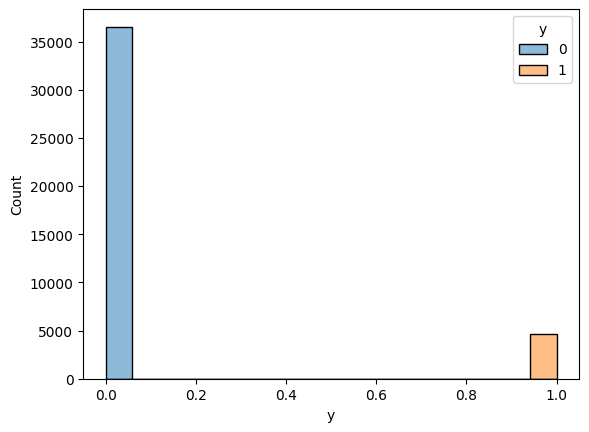

In [8]:
sns.histplot(data=proc_df, x="y", hue='y')
print(f"Imbalance: {len(proc_df[proc_df['y'] == 1]) / len(proc_df)}")

# Model the data

In [9]:
train_set, test_set = train_test_split(proc_df, test_size=0.2, random_state=50, stratify=proc_df['y'])

In [10]:
X_train, y_train = train_set.drop('y', axis=1), train_set['y'].copy()
X_test, y_test = test_set.drop('y', axis=1), test_set['y'].copy()

Train a Duummy Classifier

In [11]:
def cross_val_rf(n_est, max_d, cv=10):
    clf = RandomForestClassifier(n_estimators=n_est, max_depth=max_d)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
    print("F1: %.2f +/- %.2f" % (scores.mean(), scores.std()))

def cross_val_dm(cv=10):
    clf = DummyClassifier(strategy='stratified')
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
    print("F1: %.2f +/- %.2f" % (scores.mean(), scores.std()))
    
def test_rf(n_est, max_d, rs=60):
    clf = RandomForestClassifier(n_estimators=n_est, max_depth=max_d, random_state=rs)
    clf.fit(X_train, y_train)
    print("F1: %.2f" % f1_score(y_test, clf.predict(X_test)))

def test_dm():
    clf = DummyClassifier(strategy='stratified')
    clf.fit(X_train, y_train)
    print("F1: %.2f" % f1_score(y_test, clf.predict(X_test)))

In [12]:
test_dm()

F1: 0.11


In [17]:
cross_val_dm()

F1: 0.12 +/- 0.02


In [20]:
test_rf(200, 10)

F1: 0.36


In [19]:
cross_val_rf(200, 8)

F1: 0.30 +/- 0.04


RF F1: 0.37


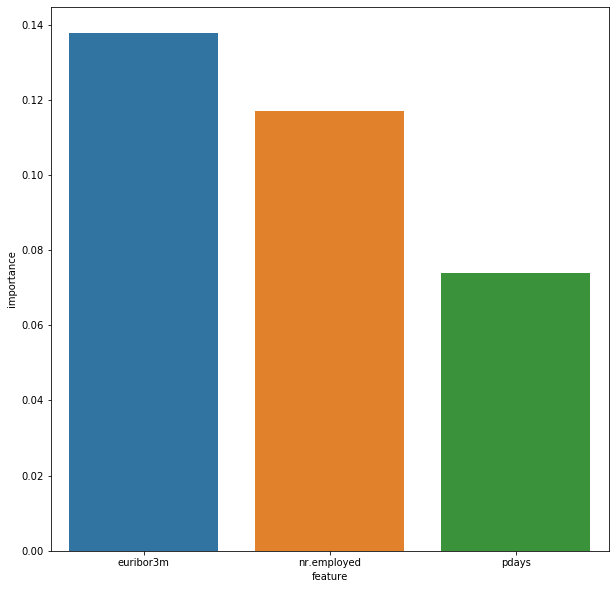

In [110]:
clf = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=60)
clf.fit(X_train, y_train)

result = pd.DataFrame({
    "feature": X_train.columns.values.tolist(),
    "importance": clf.feature_importances_
})
result = result.sort_values(by=['importance'], ascending=False).head(n=3)

fig = plt.figure(figsize=(10, 10))
sns.barplot(result, x='feature', y='importance')

print("RF F1: %.2f" % f1_score(y_test, clf.predict(X_test)))

Hyper-parameter tuning the Random Forest Classifier

# Experiments

In [2]:
proc_df = dataset.copy() # to ensure that we the original dataset is not affected.

# one hot the categorical features
COLUMNS_TO_ONE_HOT = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
proc_df = pd.get_dummies(proc_df, columns=COLUMNS_TO_ONE_HOT)

# remove the duration column
proc_df = proc_df.drop('duration', axis=1)

# label encode the target
proc_df['y'] = LabelEncoder().fit_transform(proc_df['y'])
proc_df.info()

NameError: name 'dataset' is not defined

In [1]:
classifier = RandomForestClassifier()

parameters = {
    'n_estimators': [100, 150, 200, 300, 400, 500],
    'max_depth': [None, 3, 5, 10, 15, 20 ,25],
    'max_leaf_nodes': [None, 2, 5, 10, 12, 15]
}

clf = GridSearchCV(classifier, parameters, cv=10, scoring='f1', verbose=3)

clf.fit(X_train, y_train)

NameError: name 'RandomForestClassifier' is not defined

In [91]:
clf.best_estimator_

RandomForestClassifier(n_estimators=200)

In [92]:
clf.best_score_

0.37859652745026384

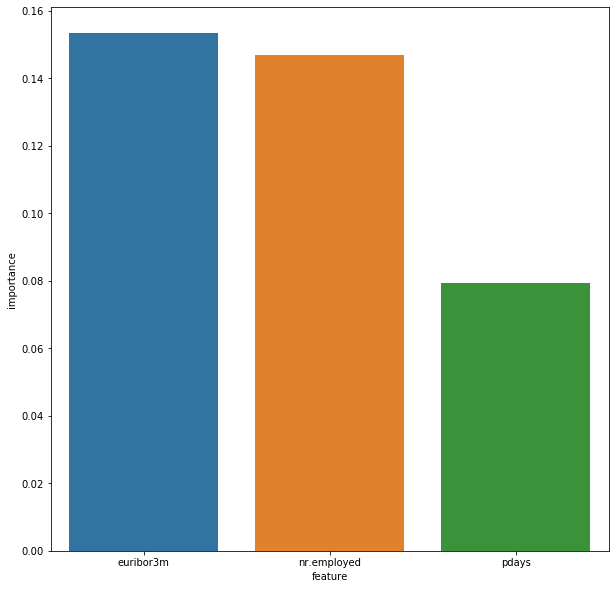

In [78]:
result = pd.DataFrame({
    "feature": X_train.columns.values.tolist(),
    "importance": clf.best_estimator_.feature_importances_
})
result = result.sort_values(by=['importance'], ascending=False).head(n=3)

fig = plt.figure(figsize=(10, 10))
sns.barplot(result, x='feature', y='importance')

In [83]:
clf = RandomForestClassifier(max_depth=10, n_estimators=200)
clf.fit(X_train, y_train)

print("Tuned RF ACC: %.2f" % accuracy_score(y_test, clf.predict(X_test)))

Tuned RF ACC: 0.90
